In [1]:
import torch
import torch.nn as nn
torch.__version__

'0.4.0'

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('data/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/*.txt'):
    category = filename.split('\\')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data\\Arabic.txt', 'data\\Chinese.txt', 'data\\Czech.txt', 'data\\Dutch.txt', 'data\\English.txt', 'data\\French.txt', 'data\\German.txt', 'data\\Greek.txt', 'data\\Irish.txt', 'data\\Italian.txt', 'data\\Japanese.txt', 'data\\Korean.txt', 'data\\Polish.txt', 'data\\Portuguese.txt', 'data\\Russian.txt', 'data\\Scottish.txt', 'data\\Spanish.txt', 'data\\Vietnamese.txt']
Slusarski


In [3]:
category_lines

{'Arabic': ['Khoury',
  'Nahas',
  'Daher',
  'Gerges',
  'Nazari',
  'Maalouf',
  'Gerges',
  'Naifeh',
  'Guirguis',
  'Baba',
  'Sabbagh',
  'Attia',
  'Tahan',
  'Haddad',
  'Aswad',
  'Najjar',
  'Dagher',
  'Maloof',
  'Isa',
  'Asghar',
  'Nader',
  'Gaber',
  'Abboud',
  'Maalouf',
  'Zogby',
  'Srour',
  'Bahar',
  'Mustafa',
  'Hanania',
  'Daher',
  'Tuma',
  'Nahas',
  'Saliba',
  'Shamoon',
  'Handal',
  'Baba',
  'Amari',
  'Bahar',
  'Atiyeh',
  'Said',
  'Khouri',
  'Tahan',
  'Baba',
  'Mustafa',
  'Guirguis',
  'Sleiman',
  'Seif',
  'Dagher',
  'Bahar',
  'Gaber',
  'Harb',
  'Seif',
  'Asker',
  'Nader',
  'Antar',
  'Awad',
  'Srour',
  'Shadid',
  'Hajjar',
  'Hanania',
  'Kalb',
  'Shadid',
  'Bazzi',
  'Mustafa',
  'Masih',
  'Ghanem',
  'Haddad',
  'Isa',
  'Antoun',
  'Sarraf',
  'Sleiman',
  'Dagher',
  'Najjar',
  'Malouf',
  'Nahas',
  'Naser',
  'Saliba',
  'Shamon',
  'Malouf',
  'Kalb',
  'Daher',
  'Maalouf',
  'Wasem',
  'Kanaan',
  'Naifeh',
  'Boutro

In [23]:
print(all_categories)

['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


In [24]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
torch.Size([5, 1, 57])


In [25]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [26]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [27]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

We now pass the inputs and previous hidden state to the newtwork to calculate next hidden state and output state.

In [28]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

In [29]:
print(output)

tensor([[-2.8920, -2.9229, -2.8419, -2.9236, -2.9198, -2.9089, -2.9366,
         -2.9437, -2.9783, -2.9376, -2.8687, -2.9564, -2.8162, -2.7952,
         -2.9679, -2.7666, -2.8075, -2.8775]])


In [30]:
input = lineToTensor("Albert")
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)

In [31]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Scottish', 15)


In [32]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Arabic / line = Said
category = French / line = Joubert
category = Vietnamese / line = Tron
category = Scottish / line = Clark
category = Portuguese / line = Moreno
category = Irish / line = Manus
category = Arabic / line = Boulos
category = Polish / line = Niemczyk
category = Irish / line = Teagan
category = German / line = Geier


In [33]:
criterion = nn.NLLLoss()

In [34]:
learning_rate = 0.005 
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [35]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 3.1155 Cabral / German ✗ (Portuguese)
10000 10% (0m 15s) 1.9265 Porcher / French ✓
15000 15% (0m 23s) 2.8954 Weiss / Portuguese ✗ (German)
20000 20% (0m 31s) 2.0071 Sault / Arabic ✗ (French)
25000 25% (0m 38s) 1.4805 Black / Scottish ✓
30000 30% (0m 45s) 0.4471 Cheng / Chinese ✓
35000 35% (0m 52s) 0.5116 Fukuoka / Japanese ✓
40000 40% (0m 59s) 0.0169 Mayuzumi / Japanese ✓
45000 45% (1m 6s) 0.7223 Seo / Korean ✓
50000 50% (1m 13s) 3.9178 Santana / Japanese ✗ (Portuguese)
55000 55% (1m 20s) 1.2597 Gomes / Portuguese ✓
60000 60% (1m 28s) 1.2196 Starek / Czech ✗ (Polish)
65000 65% (1m 35s) 0.4894 Meeuweszen / Dutch ✓
70000 70% (1m 42s) 2.0779 Maes / Portuguese ✗ (Dutch)
75000 75% (1m 50s) 1.2857 Vinnik / Russian ✓
80000 80% (1m 58s) 2.2664 Tailler / Irish ✗ (French)
85000 85% (2m 6s) 0.5528 Yuan / Chinese ✓
90000 90% (2m 14s) 1.2699 Janvier / French ✓
95000 95% (2m 22s) 1.3168 Kennedy / English ✗ (Scottish)
100000 100% (2m 29s) 1.1260 Schreier / German ✓


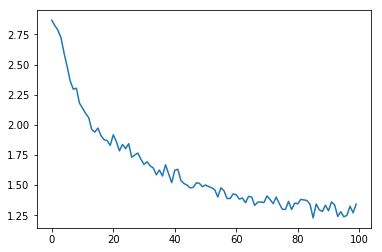

In [36]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

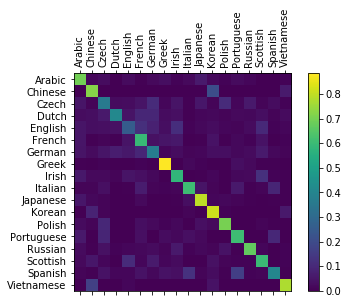

In [37]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [38]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Obama')


> Dovesky
(-0.81) Czech
(-0.99) Russian
(-2.63) Polish

> Jackson
(-0.75) Scottish
(-1.07) English
(-2.11) Russian

> Satoshi
(-0.98) Japanese
(-1.40) Italian
(-1.47) Arabic

> Obama
(-0.54) Japanese
(-2.06) Arabic
(-2.46) Spanish
